<a href="https://colab.research.google.com/github/SamruddhiMetkar/stock-price-forecasting/blob/main/kalman_filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import multivariate_normal
from sklearn.linear_model import LinearRegression
from scipy.special import logsumexp
plt.style.use('seaborn-white')

# We load the data
data = pd.read_csv("/content/ADANIPOWER.NS.csv")

# We omit the dates, adjusted close and the volume columns. And we take only the data for 2018 and 2019
#This line extracts a subset of the loaded data. It takes the last 503 rows ([-503:]) and all columns except the last two ([:,:-2]).
data = data.values[-555:,:-2]

# We train on 2018 data and we consider only open and high price
train = data[:-252,[1,4]]
train_X = train[:,0]
train_Y = train[:,1]
# We test on 2019 data
test = data[-252:,[1,4]]
test_X = test[:,0]
test_Y = test[:,1]

print(train[:5])

[[102.5 100.550003]
 [100.650002 99.849998]
 [99.5 99.849998]
 [101.400002 100.199997]
 [101.0 108.699997]]


<ipython-input-5-6ab58e3b615f>:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


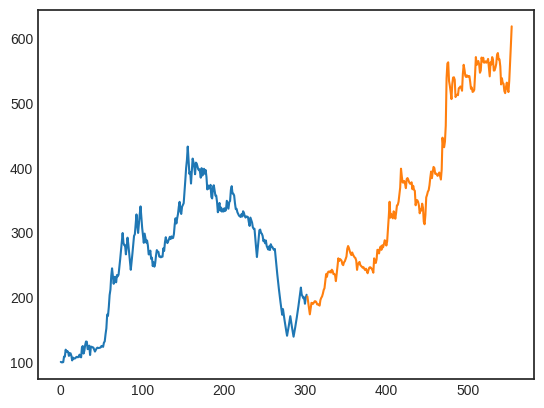

In [6]:
plt.plot(np.arange(len(train_Y)), train_Y)
plt.plot(np.arange(len(train_Y), len(test_Y) + len(train_Y)), test_Y)

In [7]:
# Initialize arrays to store the prior mean (mu), the logarithm of the prior covariance (log_p), and the logarithm of the Kalman gain (log_k).
#Set the initial values for log_p and mu[0].
def pre_filtering(x, a, b, c, f):

  T = len(x)

#mu prior mean log_p prior covariance mean log_k kalman gain logarithm
  mu = np.zeros(shape=(T))
  log_p = np.zeros(shape=(T))
  log_k = np.zeros(shape=(T))
  log_p[0] = 2
  mu[0] = x[0]

#T corresponds to the number of time steps or observations for which the filter is applied.
#It represents the length of the time series data over which the Kalman filter iterates to estimate the state of the system at each time step.
  # example we start by \mu_{1|0} and \p_{1|0} assuming we have x = (x_1, x_2,..., x_N) a vector of N elements
  for t in range(1,T):
    mu[t] = a + b*mu[t-1]    #Update Prior Mean (mu[t]): Update the prior mean at time step t using the dynamic model.
    log_p[t] = logsumexp([np.log(b**2) + log_p[t-1], np.log(c**2)])  #Update Logarithm of Prior Covariance (log_p[t]): Update the logarithm of the prior covariance at time step t based on the dynamic model parameters b and measurement noise c.
    log_k[t] = log_p[t-1] - logsumexp([log_p[t-1], np.log(f**2)])   # updating kaldman gain
  return mu, log_p, log_k

def filtering(x, y, a, b, c, f):
  T = len(y)
  mu, log_p, log_k = pre_filtering(x, a, b, c, f)  #callinf pre filtering function to get prior mean and covariance

  mu_filt = np.zeros(shape=(T))  # initialise to store filtered mean
  p_filt = np.zeros(shape=(T))   #initialise array to store covariance filtered

  for t in range(T):
    mu_filt[t] = mu[t] + np.exp(log_k[t])*(y[t] - mu[t])  #update filtered mean at t time using  pre-filtered mean, Kalman gain, and observation.
    p_filt[t] = (f**2) * np.exp(log_k[t])  #Update the filtered covariance at time step t using the pre-filtered covariance and the measurement noise.

  return mu_filt, p_filt


  #The Kalman gain is computed based on the predicted covariance and the measurement noise.
  #It represents the trade-off between the predicted state and the observed measurement

In [8]:

x = train_Y
y = train_X

T = len(y)

x_t = x[1:]
x_t_1 = x[:-1]

f_2 = ((y - x)**2).sum() / len(y)
b = ((T-1)*(x_t * x_t_1).sum() - x_t.sum() * x_t_1.sum())/((T-1)*((x_t_1**2).sum()) - x_t_1.sum()**2)
a = (x_t - b*x_t_1).sum() / (T-1)
c_2 = ((x_t - a - b*x_t_1)**2).sum() / (T-1)

print(np.sqrt(f_2), b, a, np.sqrt(c_2))

8.400283127600186 0.9906765081257176 2.7574409757331244 9.054082501797044


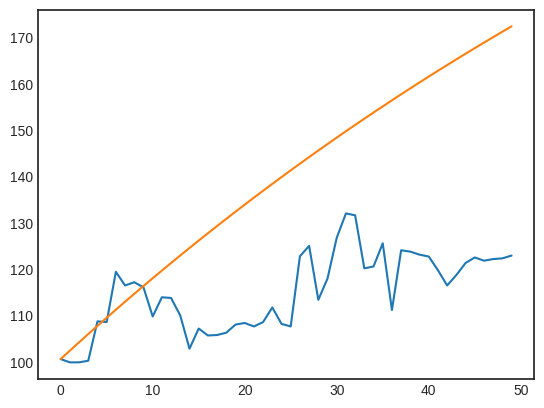

In [9]:
mu, log_p, log_k = pre_filtering(x, a, b, np.sqrt(c_2), np.sqrt(f_2))
plt.plot(np.arange(50), x[:50])
plt.plot(np.arange(50), mu[:50])

2.4702808924549147


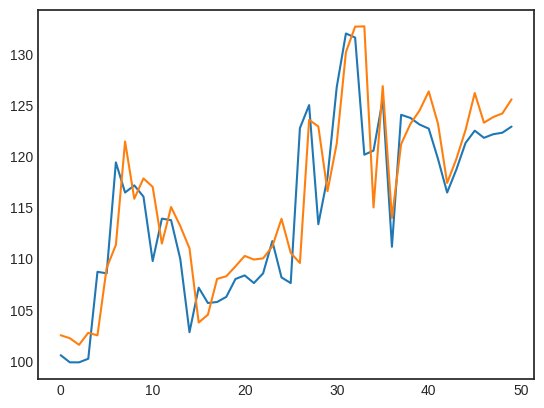

In [10]:
mu_filt, p_filt = filtering(x, y, a, b, np.sqrt(c_2), np.sqrt(f_2))
plt.plot(np.arange(50), x[:50])
plt.plot(np.arange(50), mu_filt[:50])



print(np.mean(np.abs((x - mu_filt) / x)) * 100)

worst baseline  2.026084083090855
current baseline  1.9818004113219994


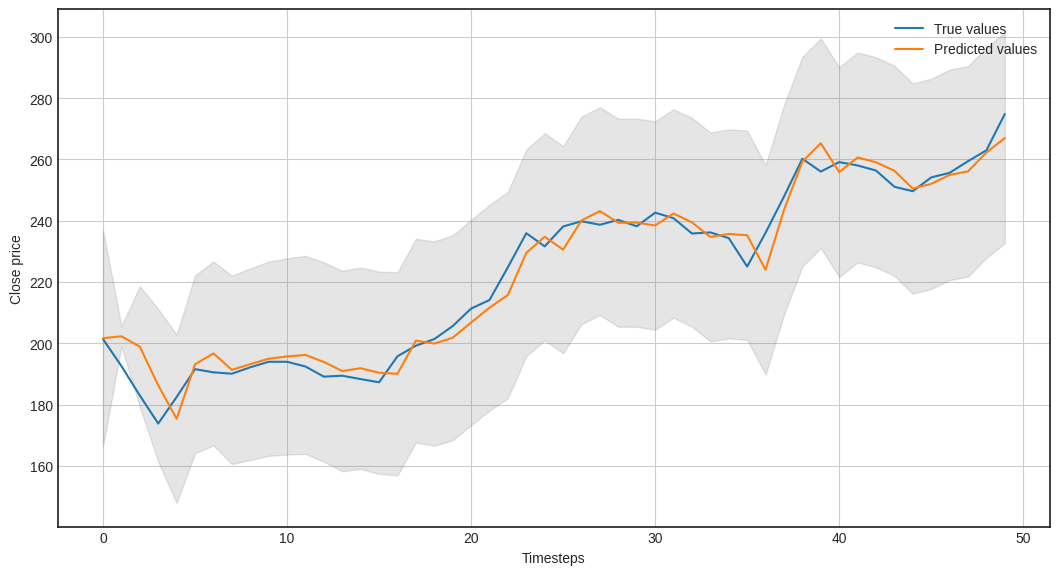

In [11]:

def log_gaussian(mu, sigma, x):
  part1 = np.sqrt(2*np.pi)*sigma
  part2 = -0.5 * (x - mu)**2 * (1/sigma**2)
  return -np.log(part1) + part2

x_test = test_Y
y_test = test_X

mu_fore, p_fore = filtering(x_test, y_test, a, b, np.sqrt(c_2), np.sqrt(f_2))

plt.figure(figsize=(6.4*2, 4.8*1.4))
plt.plot(np.arange(50), x_test[:50])
plt.plot(np.arange(50), mu_fore[:50])
plt.fill_between(np.arange(50), mu_fore[:50] - p_fore[:50] / 2, mu_fore[:50] + p_fore[:50] / 2, color='gray', alpha=0.2)
plt.legend(['True values', 'Predicted values'])
plt.xlabel('Timesteps')
plt.ylabel('Close price')
plt.grid()
#Worst Baseline: The "worst baseline" calculates the MAPE by using the last observed value from the test data as the baseline for comparison. In other words,
# it measures the error of the prediction relative to the most recent observed value in the test data.
print('worst baseline ', np.mean(np.abs((x_test - test[:,0]) / x_test))* 100)
# The "current baseline" calculates the MAPE by using the current prediction value as the baseline for comparison.
# In this case, the error is measured relative to the current predicted value.
print('current baseline ', np.mean(np.abs((x_test - mu_fore) / x_test))* 100)


In [12]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import multivariate_normal
from sklearn.linear_model import LinearRegression
from scipy.special import logsumexp
plt.style.use('seaborn-white')

# We load the data
data = pd.read_csv("/content/ADANIPOWER.NS.csv")

# We omit the dates, adjusted close and the volume columns. And we take only the data for 2018 and 2019
data = data.values[-503:,:-2]

# We train on 2018 data and we consider only open and high price
train = data[:-252,[1,4]]
train_X = train[:,0]
train_Y = train[:,1]
# We test on 2019 data
test = data[-252:,[1,4]]
test_X = test[:,0]
test_Y = test[:,1]

# Compute the difference in price
diffs = train_X[:-1] - train_X[1:]

# If the difference is positive then label 1 otherwise label 0
labels = np.where(diffs >= 0, 1, 0)

# For the first element of the time series we can put either 0 or 1
labels = np.insert(labels, 0, 0)

# Do the same thing for the test set
diffs_test = test_X[:-1] - test_X[1:]
diffs_test = np.insert(diffs_test, 0, test_X[0] - train_X[-1])
labels_test = np.where(diffs_test >= 0, 1, 0)

<ipython-input-12-8de6c14d4aa2>:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


worst baseline  2.026084083090855
current baseline  1.9661323496348688


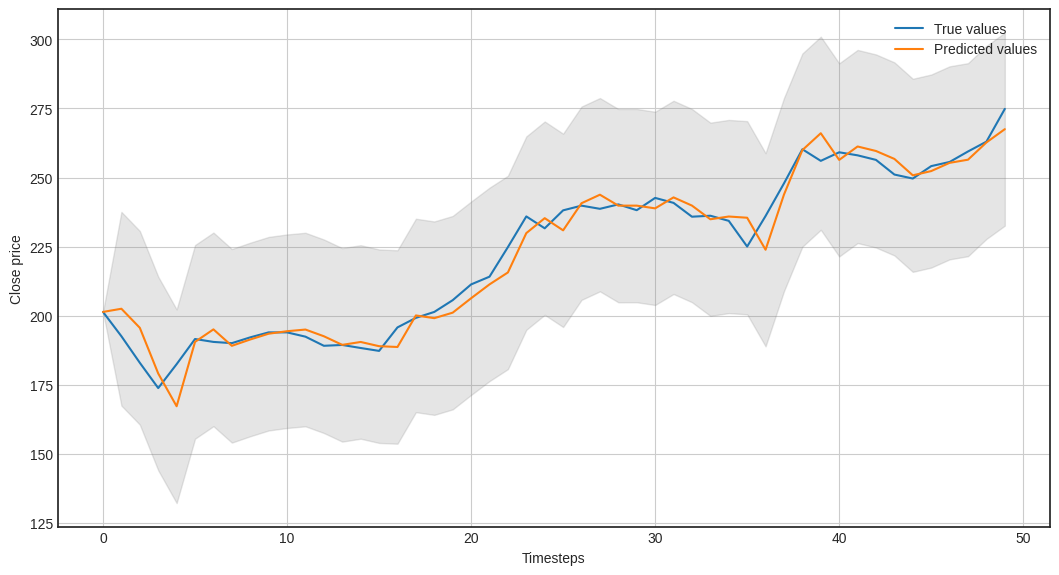

In [13]:

def pre_filtering(x, a, b, c, f):

  T = len(x)

  mu = np.zeros(shape=(T))
  p = np.zeros(shape=(T))
  k = np.zeros(shape=(T))
  p[0] = 10000
  mu[0] = x[0]

  # example we start by \mu_{1|0} and \p_{1|0} assuming we have x = (x_1, x_2,..., x_N) a vector of N elements
  for t in range(1,T):
    mu[t] = a + b*mu[t-1]
    p[t] = (b**2) * p[t-1] + c**2
    k[t] = p[t] / (p[t] + f**2)

  return mu, p, k

def filtering(x, y, a, b, c, f):
  T = len(y)
  mu, p, k = pre_filtering(x, a, b, c, f)

  mu_filt = np.zeros(shape=(T))
  p_filt = np.zeros(shape=(T))

  for t in range(T):
    mu_filt[t] = mu[t] + k[t]*(y[t] - mu[t])
    p_filt[t] = (f**2) * k[t]

  return mu_filt, p_filt

x_test = test_Y
y_test = test_X

mu_fore, p_fore = filtering(x_test, y_test, a, b, np.sqrt(c_2), np.sqrt(f_2))

plt.figure(figsize=(6.4*2, 4.8*1.4))
plt.plot(np.arange(50), x_test[:50])
plt.plot(np.arange(50), mu_fore[:50])
plt.fill_between(np.arange(50), mu_fore[:50] - p_fore[:50] / 2, mu_fore[:50] + p_fore[:50] / 2, color='gray', alpha=0.2)
plt.legend(['True values', 'Predicted values'])
plt.xlabel('Timesteps')
plt.ylabel('Close price')
plt.grid()

print('worst baseline ', np.mean(np.abs((x_test - test[:,0]) / x_test))* 100)
print('current baseline ', np.mean(np.abs((x_test - mu_fore) / x_test))* 100)
